In [1]:
import os
os.chdir("../")
print("Moved up")

Moved up


In [2]:
import importlib
import copy
import pickle
import typing as tp
from functools import partial

import jax
import jax.numpy as jnp
import jax.flatten_util as fu
from flax import linen as nn  # Linen API
import numpy as np
import matplotlib.pyplot as plt
import optax
import math

from tqdm import tqdm
import time

import lib_data
import utils
import modules
import callbacks

%env XLA_PYTHON_CLIENT_MEM_FRACTION=.9
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("devices", jax.devices())

shade_colours = plt.get_cmap('Set3')
dark_colours = plt.get_cmap('tab10')
all_colours = plt.get_cmap('tab20')

def light_colours(i):
    return all_colours(2*i+1)

2025-04-29 14:08:46.592518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745932126.607504  242687 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745932126.611740  242687 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.9
devices [CudaDevice(id=0)]


In [3]:
# %env XLA_FLAGS=--xla_gpu_deterministic_ops=true
# %env XLA_FLAGS=--xla_gpu_deterministic_reductions=true
%env XLA_FLAGS=--xla_gpu_deterministic_ops=true --xla_gpu_deterministic_reductions=true

env: XLA_FLAGS=--xla_gpu_deterministic_ops=true --xla_gpu_deterministic_reductions=true


# Dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


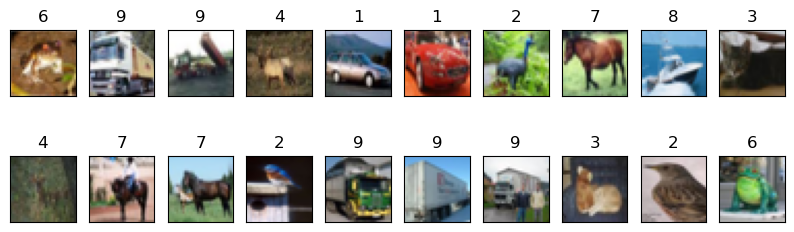

3


In [3]:
#-----------------------------------------------------------------------------------------------------------------------------
n_out = 10

n_train: int = 512 * n_out
n_eval: int = 200 * n_out
n_hess: int = 512 * n_out
use_mse = False

importlib.reload(lib_data)
def __get_datasets():
    datasets = lib_data.get_cifar10(flatten=False, tr_indices=n_train, te_indices=n_eval, hess_indices=n_hess,
                            tr_classes=n_out, te_classes=n_out, hess_classes=n_out, one_hot = use_mse, 
                              augmentations = False, visualise=True)

    data_name = "cifar10_1L_"+str(n_out)+"cl_"+str(n_train) + "_" + str(n_eval) 
    print(len(datasets))
    return datasets, data_name

datasets, data_name = __get_datasets()

# Architecture

In [4]:
importlib.reload(modules)

def __get_arch__(name_only=False):
    n_blocks = 3
    layers_per_block = 3
    depth_per_layer = 2
    base_width = 8
    use_DO = False
    use_BN = True
    sc_conv = "Identity"
    depth_name = str(int(2 + n_blocks * layers_per_block * depth_per_layer))

    model_name = f"ResNet{depth_name}_base{base_width:d}_{sc_conv}"
    if use_DO:
        model_name += "_DO"
    if use_BN:
        model_name += "_BN"

    if name_only:
        return None, model_name

    model = modules.ResNet(n_blocks, layers_per_block, depth_per_layer, use_DO=use_DO, use_BN=use_BN,
                           sc_conv=sc_conv)

    return model, model_name

model_arch, model_name = __get_arch__()
print(model_name)

ResNet20_base8_Identity_BN


# Optimizer

In [5]:
#-----------------------------------------------------------------------------------------------------------------------------
importlib.reload(modules)
from optax import contrib

def __get_optim__(warmup_steps, lr, b1, b2, b3, option="", rho=None, sync_period=1):
    # warmup_steps, lr, b1, b2, b3 = hyps['warmup_steps'], hyps['lr'], hyps['b1'], hyps['b2'], hyps['b3']
    if option == 'sam':
        assert rho is not None
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        base_opt = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        adv_opt = modules.get_sgd_optimizer(rho, b1, b2, b3, verbose=False)
        optimizer = contrib.sam(base_opt, adv_opt, sync_period=sync_period, opaque_mode=True) # sam opt
        optim_name = f"sgdFam-SAM_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}_rho{rho}_syncT{sync_period}"

    else:
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        optimizer = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        optim_name = f"sgdFam_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}"
        
    return optimizer, optim_name

optimizer, optim_name = __get_optim__(2, 0.1, 0, 0, 0)

# Model Params (Fixed and Tuned)

In [6]:
#-----------------------------------------------------------------------------------------------------------------------------
import itertools
### FIXED
warmup_steps = 0
bs = 64
eval_bs = 2000
n_epochs = 1000
loss_fn = optax.softmax_cross_entropy_with_integer_labels
# loss_fn = optax.squared_error

# FLEXIBLE
# lr = 0.005
# beta_list = [(0., 0., 0.), (0., 0.99, 0.)]
# optim_hp = LR, B1, B2, B3, SAM, Rho, sync_period
optim_hp_list = [
    (0.1, 0., 0., 0., False, 0., 1), 
    # (0.1, 0., 0., 0., True, 0.1, 1), 
    # (5e-3, 0., 0.9, 0., False, 0., 1), 
    # (5e-3, 0., 0.9, 0., True, 0., 1), 
    # (5e-3, 0., 0.9, 0., True, 0.1, 1), 
    # (5e-3, 0.9, 0.99, -1.0, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -1.0, True, 0.01, 1), 
    # (5e-3, 0.9, 0.99, -0.5, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.1, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.05, False, 0., 1),
    # (5e-3, 0.9, 0.99, -0.01, False, 0., 1),
    # (5e-3, 0.9, 0.99, -0.005, False, 0., 1), 
    # (5e-3, 0.9, 0.99, -0.001, False, 0., 1), 
]
seed_list = [x for x in range(1)]
# seed_list = [1352] # just to check new SAM with new loss_wrap
# sam_list = [False, True]
s = [optim_hp_list, seed_list]
hyp_list = list(itertools.product(*s))
print(len(hyp_list))

1


# Callbacks

In [7]:
#-----------------------------------------------------------------------------------------------------------------------------
sws = 5
cb_freq = 1
hess_freq = int(1e8) # really large
# hess_freq = 10
importlib.reload(callbacks)
def __get_cbs__(state, option, compute_hessian=False):
    bn = False if option == "" else True
    cbs = []
    cbs.append(callbacks.saveWeightsCB(sws, grad=True))
    # cbs.append(callbacks.thinCB(thin_freq=cb_freq))

    if compute_hessian:
        hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=(datasets[2].data[:n_hess], datasets[2].targets[:n_hess]), 
                            save_freq=hess_freq, hess_bs=n_hess, state=state, bn=bn)
        cbs.append(hvpCB)   
        specCB = callbacks.spectrumCB(n_eigs=20, n_evecs=10, 
                    loss_fn=loss_fn, seed=seed, hvpCB=hvpCB, save_freq=hess_freq, verbose=True)
        cbs.append(specCB)

    esCB = callbacks.earlyStopCB(acc_threshold=0.999, cbs=None, min_eps=sws, max_eps=n_epochs, conseq_eps=2,
                                 final_cbs=[hvpCB, specCB], verbose=False, low_eps=max(sws, 100), low_thresh=0.11, )
    cbs.append(esCB)
    return cbs


# Train State

In [8]:
from flax import struct                # Flax dataclasses
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
importlib.reload(modules)

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

class TrainStateBN(train_state.TrainState):
    metrics: Metrics
    batch_stats: tp.Any

class TrainStateSAM(modules.TrainStateSAM):
    metrics: Metrics
    batch_stats: tp.Any

def create_train_state(model, optimizer, inputs, rng, option=""):
    """Creates an initial `TrainState`."""
    if option == "":
        params = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :]))['params'] # initialize parameters by passing a template image
        
        tx = optimizer
        return TrainState.create(
          apply_fn=model.apply, params=params, tx=tx, metrics=Metrics.empty())
        
    elif option == "bn":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainStateBN.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
        
    elif option == "sam":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainStateSAM.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
    else:
        raise NotImplementedError
        
        

# Training

In [9]:
#-----------------------------------------------------------------------------------------------------------------------------
import training
importlib.reload(training)

load_files = False
compute_hessian = True
force_train = False

all_mh = []
all_exp_names = []

for hyp in hyp_list:
    
    metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

    lr, b1, b2, b3, sam, sam_rho, sync_T = hyp[0]
    seed = hyp[1]
    option = 'sam' if sam else "bn"
    
    if datasets is None:
        datasets, data_name = __get_datasets__()
    
    train_loader = lib_data.NumpyLoader(datasets[0], batch_size=bs, shuffle=True)
    for sample_batch in train_loader:
        break
    
    test_loader = lib_data.NumpyLoader(datasets[1], batch_size=eval_bs)
    dataloaders = [train_loader, test_loader]
    
    model, model_name = __get_arch__()
    model_name += "_seed"+str(seed)

    optim, optim_name = __get_optim__(warmup_steps, lr, b1, b2, b3, option=option, rho=sam_rho, sync_period=sync_T)
    optim_name += f"_bs{bs}"

    init_rng = jax.random.PRNGKey(seed)
    state = create_train_state(model, optim, sample_batch[0], init_rng, option=option)
    del init_rng  # Must not be used anymore.
    
    cbs = __get_cbs__(state, option, compute_hessian=compute_hessian)
    cb_name_str = utils.get_callback_name_str(cbs)
    cb_name_list = utils.get_callback_name_list(cbs)
    # break
    num_params = utils.count_params(state.params)
    print("num params", num_params)

    experiment_name = utils.get_now() + "_" + data_name + "_" + model_name + "_" + optim_name
    
    try:
        if force_train:
            raise FileNotFoundError
        experiment_name, lse = utils.find_latest_exp(experiment_name, n_epochs, save_freq=cb_freq, 
                                                   cbs=cb_name_list, unknown_lse=True, verbose=False)
        metrics_history = utils.load_thing("traj/" + experiment_name + "/metrics.pkl")
        print(f"tr_acc: {metrics_history['train_accuracy'][-1]:0%}, te_acc: {metrics_history['test_accuracy'][-1]:0%}")
        metrics_history['lse'] = [lse]

    except FileNotFoundError:
        metrics_history = training.train_model(state, model, loss_fn, metrics_history, n_epochs, dataloaders, \
                                                   experiment_name, cbs, option=option, force_fb=False, tqdm_over_epochs=1)         

    if compute_hessian:
        eigvals = utils.load_thing("traj/" + experiment_name + "/eigvals.pkl")
        metrics_history['eigvals'] = eigvals
        eigvecs = utils.load_thing("traj/" + experiment_name + "/eigvecs.pkl")
        metrics_history['eigvecs'] = eigvecs
        print(f"sharp: {metrics_history['eigvals'][-1][0]}")
    all_mh.append(metrics_history)
    all_exp_names.append(experiment_name)
    
    print(experiment_name, "complete")
    print("\n ---------------------------------------------------------------------------------------------------------\n")
# Training: datasets, hps, arch_func, optim_func, cb_func, -> train model


num params 68050
tr_acc: 100.000000%, te_acc: 53.850001%
sharp: 12281.2451171875
250428-1627_cifar10_1L_10cl_5120_2000_ResNet20_base8_Identity_BN_seed0_sgdFam_1b0.0_2b0.0_3b0.0_lr0.1_warmup0_bs64 complete

 ---------------------------------------------------------------------------------------------------------



In [10]:
import foolbox as fb


In [11]:
print(np.min(sample_batch[0]), np.max(sample_batch[0]))
print(np.mean(sample_batch[0]))

-1.9894737 2.1308641
0.050161604


In [12]:
def model_apply(x):
    return state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, x, train=False)
    
fmodel = fb.JAXModel(model_apply, bounds=(-2.5, 2.5))

attack = fb.attacks.LinfPGD()
epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]
# _, advs, success = attack(fmodel, images, labels, epsilons=epsilons)

In [61]:
print(eval_bs)
adv_loader = lib_data.NumpyLoader(datasets[1], batch_size=100)
for adv_inputs, adv_targets in adv_loader:
    break

2000


In [62]:
adv_inputs = jnp.array(adv_inputs)  # if not already
adv_targets = jnp.array(adv_targets)
print(adv_inputs.shape, adv_targets.shape)

(100, 32, 32, 3) (100,)


In [63]:
_, advs, success = attack(fmodel, adv_inputs, adv_targets, epsilons=epsilons)

0.0


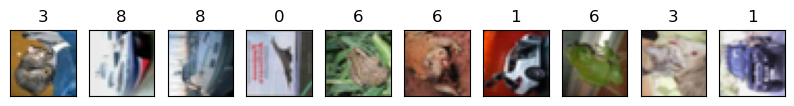

0.001


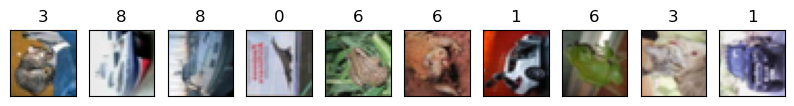

0.01


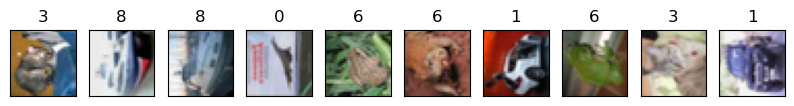

0.03


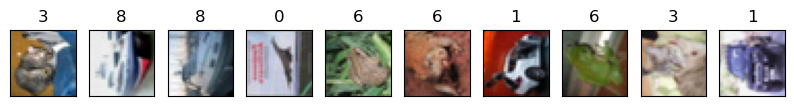

0.1


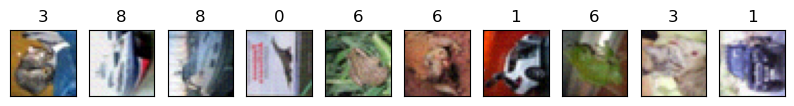

0.3


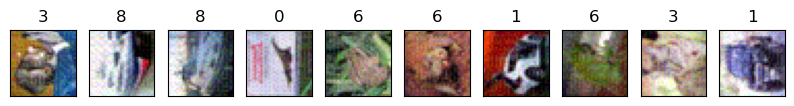

0.5


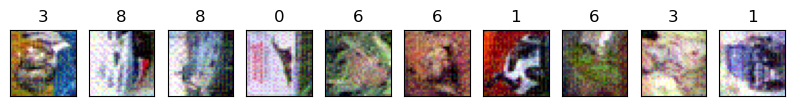

1.0


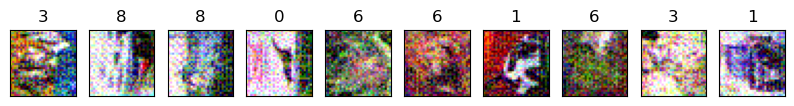

In [64]:
importlib.reload(lib_data)
def unnormalize(x):
    means, stds = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
    
    x = x*jnp.array(stds) + jnp.array(means)
    x = jnp.clip(x, 0, 1)
    x = jnp.swapaxes(x, 1, 3)
    return x


# lib_data.visualise_cifar((unnormalize(adv_inputs), adv_targets), verbose=False)
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    print(epsilon)
    lib_data.visualise_cifar((unnormalize(advs[i]), adv_targets), verbose=False)
    


In [65]:
print(len(advs))

8


In [66]:
print(n_hess)

5120


In [67]:
from tabulate import tabulate


In [68]:
print(adv_targets.shape)

(100,)


In [21]:
j=0
this_batch = (advs[i][j][np.newaxis, :], adv_targets[j][np.newaxis])
print(this_batch[0].shape, this_batch[1].shape)


(1, 32, 32, 3) (1,)


In [69]:
import time

In [70]:
table_out = []

def grads_hvp_from_batch(state, batch):
    tmp_hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=this_batch, 
                        save_freq=hess_freq, hess_bs=100, state=state, bn=True)
    tmp_hvpCB.forward(state=state)
    hvp_cl = lambda v: tmp_hvpCB.hvp(state.params, v)

    def get_loss(params):
        preds, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                                            this_batch[0], train=False, mutable=['batch_stats'])
        loss = loss_fn(preds, this_batch[1]).mean()
        return loss, updates

    grad_fn = jax.value_and_grad(get_loss, has_aux=True)
    (loss, updates), grads = grad_fn(state.params)
    flat_params, _ = fu.ravel_pytree(state.params)
    flat_grads, _ = fu.ravel_pytree(grads)
    hvp_out = hvp_cl(flat_grads)
    return flat_grads, hvp_out

start_time = time.time()
for i in range(len(epsilons)):
    epsilon = epsilons[i]
    print(i, epsilon, time.time()-start_time)
    epsilon_list = []
    for j in range(100):
        this_batch = (advs[i][j][np.newaxis, :], adv_targets[j][np.newaxis])
        flat_grads, hvp_out = grads_hvp_from_batch(state, this_batch)
        a = np.linalg.norm(flat_grads)**2
        b = np.linalg.norm(hvp_out)
        out_list = [epsilon, j, a, b, a/b]
        epsilon_list.append(out_list)

    # -- compute batch stats over mean -- 
    for k in range(1):
        this_batch = (advs[i], adv_targets)
        flat_grads, hvp_out = grads_hvp_from_batch(state, this_batch)
        a = np.linalg.norm(flat_grads)**2
        b = np.linalg.norm(hvp_out)
        out_list = [epsilon, 'mean', a, b, a/b]
        epsilon_list.append(out_list)

    # print(f"{epsilon}, {np.linalg.norm(flat_grads)**2:.2f}, {np.linalg.norm(HVP_out):.2f}, {np.linalg.norm(flat_grads)**2/np.linalg.norm(HVP_out):.2E}, {epsilon*np.linalg.norm(flat_grads)**2/np.linalg.norm(HVP_out):.2E}")

    table_out.append(epsilon_list)
    # print(tabulate([epsilon, a, b, a/b, epsilon*a/b]))
    

0 0.0 0.00024390220642089844
1 0.001 205.30282592773438
2 0.01 404.7801172733307
3 0.03 610.7199289798737
4 0.1 806.861573934555
5 0.3 1006.058100938797
6 0.5 1205.2725353240967
7 1.0 1403.9527299404144


In [23]:
selected_out = []
for el in table_out:
    # print(tabulate([el[0], el[1], el[-1]], headers=[r"$\epsilon$", "ind", "|g|^2", "|Hg|", "|g|^2/|Hg|"]))
    selected_out.append(el[0])
    selected_out.append(el[1])
    selected_out.append(el[-1])
    # selected_out.append([np.nan, np.nan, np.nan, np.nan, np.nan, ])

print(tabulate(selected_out, headers=["eps", "ind", "|g|^2", "|Hg|", "|g|^2/|Hg|"]))


  eps  ind       |g|^2      |Hg|    |g|^2/|Hg|
-----  -----  --------  --------  ------------
0      0       1740.84   10681.4     0.162978
0      1       7918.09   72951.1     0.10854
0      mean    1012.09   11694.1     0.0865474
0.001  0       1745.82   10710.2     0.163006
0.001  1       7939.65   73120.1     0.108584
0.001  mean    1014.99   11723.7     0.0865762
0.01   0       1795.12   11022.8     0.162856
0.01   1       8086.13   74350.1     0.108757
0.01   mean    1034.69   11897.9     0.0869642
0.03   0       1896.58   11604.2     0.163439
0.03   1       8288.51   75714.6     0.10947
0.03   mean    1074.97   12304.2     0.0873661
0.1    0       2325.94   14322.9     0.162393
0.1    1       9271.77   83478.2     0.111068
0.1    mean    1248.37   13982.4     0.0892811
0.3    0       4000.48   25202.6     0.158733
0.3    1      12677.4   107963       0.117424
0.3    mean    1904.75   20273.7     0.0939518
0.5    0       6247.37   40370.3     0.154752
0.5    1      17342.8   1411

In [74]:
table_out_np = np.array(table_out)
print(table_out_np.shape)
table_out_np = table_out_np.reshape(-1, 5)
print(table_out_np.shape)

(8, 101, 5)
(808, 5)


In [82]:
tau = [float(table_out_np[t][4])/float(table_out_np[t%101][4]) for t in range(table_out_np.shape[0])]
tau = np.array(tau)
tau = tau.reshape(8, -1).T

In [85]:
print(tau.shape)

(101, 8)


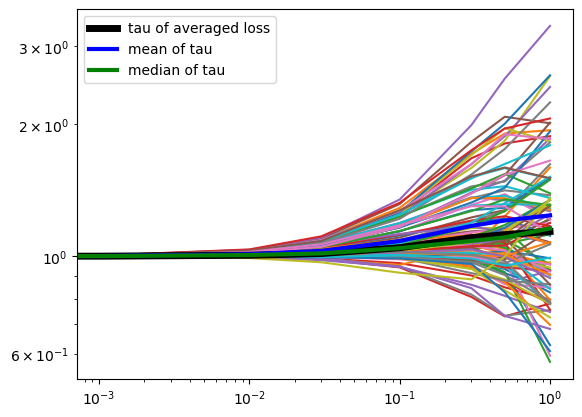

In [96]:
for x in range(100):
    plt.plot(epsilons, tau[x], label='__no_legend__')
    # for t in tau[x]:
        # plt.scatter(x, t)
plt.plot(epsilons, tau[-1], c='k', label='tau of averaged loss', linewidth=5)
plt.plot(epsilons, np.mean(tau[:-1, :], axis=0), c='b', label='mean of tau', linewidth=3)
plt.plot(epsilons, np.median(tau[:-1, :], axis=0), c='g', label='median of tau', linewidth=3)

plt.yscale('log')
plt.xscale('log')
plt.legend()

In [97]:
np.save("tau100.npy", tau)
np.save("tau100_ton.npy", table_out_np)

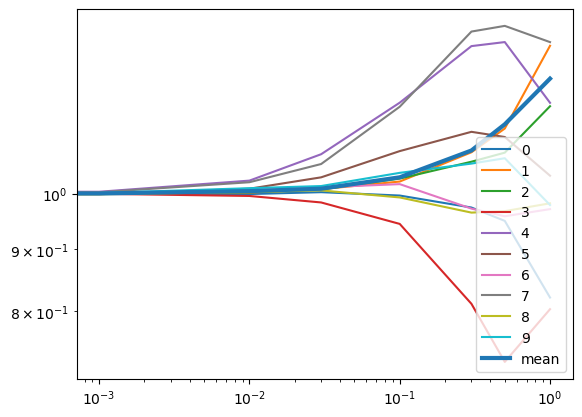

In [60]:
for x in range(10):
    plt.plot(epsilons, tau[x], label=x)
    # for t in tau[x]:
        # plt.scatter(x, t)
plt.plot(epsilons, tau[-1], label='mean', linewidth=3)

plt.yscale('log')
plt.xscale('log')
plt.legend()

In [117]:
print(tabulate(table_out, headers=[r"$\epsilon$", "|g|^2", "|Hg|", "|g|^2/|Hg|", "\epsilon*|g|^2/|Hg|"]))


  $\epsilon$     |g|^2      |Hg|    |g|^2/|Hg|    \epsilon*|g|^2/|Hg|
------------  --------  --------  ------------  ---------------------
       0       441.827   7492.88     0.0589662            0
       0.001   442.955   7504.43     0.0590258            5.90258e-05
       0.01    453.411   7611.11     0.0595722            0.000595722
       0.03    477.644   7851.46     0.060835             0.00182505
       0.1     574.654   8753.66     0.0656473            0.00656473
       0.3     960.31   11780.5      0.0815167            0.024455
       0.5    1530.65   15443.7      0.0991118            0.0495559
       1      3826.39   26149.9      0.146325             0.146325


In [111]:
a = np.linalg.norm(flat_grads)**2
b = np.linalg.norm(HVP_out)
out_list = [[a, b, a/b, epsilon*a/b]]
print(out_list)
print(tabulate(out_list, headers=[r"$\gamma$"]))


[[3826.3892504477553, 26149.904, 0.14632517224565986, 0.14632517224565986]]
                              $\gamma$
-------  -------  --------  ----------
3826.39  26149.9  0.146325    0.146325


(2001, 20)
[39.71518326 44.82378387 30.31642914 ... 13.93208599 11.56198311
 16.32165146]


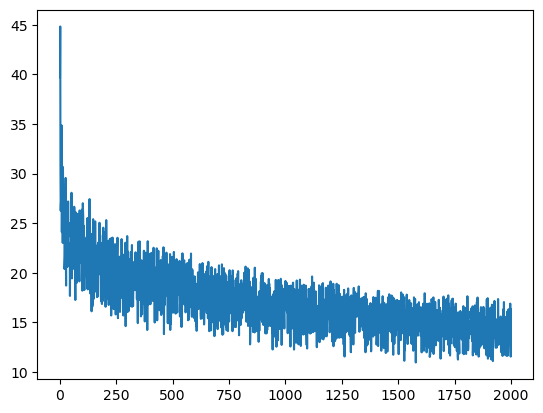

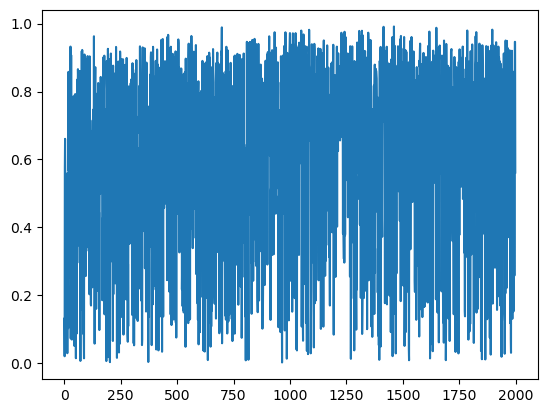

In [29]:
# eigvals, lr=0.01
print(all_mh[0]['eigvals'].shape)
print(all_mh[0]['eigvals'][:, 0])
plt.plot(all_mh[0]['eigvals'][:, 0])
plt.show()
eigsims = [utils.cos_sim(all_mh[0]['eigvecs'][i-1, 0, :], all_mh[0]['eigvecs'][i, 0, :]) for i in range(len(all_mh[0]['eigvals'])-1)]
plt.plot(eigsims)

In [23]:
# eigvals, lr=0.2
print(all_mh[0]['eigvals'].shape)
print(all_mh[0]['eigvals'][:, 0])

(704, 20)
[39.71518326 11.82230568  9.07498455  7.12147903 13.24570751 10.77616882
  6.29170704  7.09070778  7.75572872  8.03465271 11.73704433  6.67467737
  7.30640173  9.36815643  6.70754528  5.79431057  5.46358156 10.65130234
  9.10431957  8.87966251  6.70225382  5.67819118  7.21564388  8.72601986
  9.95867825  7.34283781  7.28374195  7.68227243 10.25885296  8.00736523
  6.92336321  6.23756313  5.02646303  7.47823286  7.39140224  6.71130753
  8.64813614  6.07062721  6.7294836   9.48208904  5.22375822  5.74337435
  6.42279673  7.49752712  6.07046652  4.92627001  7.34147358  6.62745571
  6.66373873  6.29183912 12.21033096  7.20066929  6.61234713  5.95590973
  5.91611958 11.10954952  6.25927734  5.32333851  7.50041103 11.35489941
  6.83393335  8.41162872  7.7197237   7.6334672  12.50511074  7.22840118
  7.37899637  5.49183798 10.69256878  6.24623823  7.78843212  7.4550786
  8.12653542  9.00067997  5.75601435  7.49188519  9.50530338  7.79469299
  9.43052006  8.22378445  7.33066177  8.65

In [18]:
# eigvals, lr = 0.1
print(all_mh[0]['eigvals'].shape)
print(all_mh[0]['eigvals'][:, 0])

(910, 20)
[39.71518326 16.27466393 10.51674557 19.7081337  14.00461102 23.48654556
 17.66197395 17.6255722  12.95594883 17.89126015 13.02660465 13.28712082
  8.62105274 17.50235176 15.46588802 22.27029037 12.6411953  10.0983696
 17.27967834 13.47455406 10.60612392 11.81336689  9.90215206 15.77715969
 14.03528309 15.14283085 10.81661224 10.86057854 18.4017601  10.80607033
 12.52266121 12.87731075 13.15389442 12.49623489 10.1957531  12.67800713
 15.67178631 12.01728439 20.66334915 12.71861649 15.22563744  9.69989777
 13.3868227  10.73252296 11.27174759 15.67815304 12.64178848  9.94017315
 12.54415894 12.70850277 16.39362907 13.9070015  11.77668858  9.74629211
 11.54806519 12.11645317 15.39482212 12.79417515 16.19164467 12.03396225
 11.55394459 13.86048317 11.70459461 14.08983231 14.03429985 12.37598801
 10.20997047  9.77095985 10.52248859 12.68654251 15.82343578 14.40832615
 10.17172813 13.50706673 10.93420601  8.96091747 11.24863911 13.30076694
 13.76229191 12.65942478  9.4236412  10.60

In [55]:
print(all_mh[0]['eigvecs'].shape)
eigvecs = all_mh[0]['eigvecs'].copy()
print(utils.cos_sim(eigvecs[1, 0, :], eigvecs[1, 1, :]))
print(utils.cos_sim(eigvecs[2, 0, :], eigvecs[3, 0, :]))
print(utils.cos_sim(eigvecs[3, 0, :], eigvecs[4, 0, :]))
print(utils.cos_sim(eigvecs[4, 0, :], eigvecs[5, 0, :]))




(101, 10, 7850)
7.774761e-05
0.70088035
0.48960674
0.5668334


In [29]:
print(all_mh[0].keys())

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy', 'lse', 'eigvals'])


In [20]:
print(len(optim_hp_list), len(all_mh))

13 13


# Results

In [29]:
optim_names = ['SGD', 'SGD-SAM', 'ADAM', 'ADAM-SAM-R0', 'ADAM-SAM', 'ADAM-UB-1e0', 'ADAM-UB-1e0-SAM', 'ADAM-UB-5e-1','ADAM-UB-1e-1', 'ADAM-UB-5e-2', 'ADAM-UB-1e-2', 'ADAM-UB-5e-3','ADAM-UB-1e-3']
stat_names = ['train_accuracy', 'test_accuracy', 'lse']
n_seeds = len(seed_list)
for i in range(len(optim_hp_list)):
    stats = [ 0 for j in range(len(stat_names))]
    for j in range(len(stats)):
        for k in range(n_seeds*i, n_seeds*i+n_seeds):
            stats[j] += all_mh[k][stat_names[j]][-1]
    out = f"{optim_names[i]}"
    for j in range(len(stats)):
        out += f", {stat_names[j]}:{stats[j]/n_seeds}"
    print(out)
    # print(optim_hp_list[i], np.mean(all_mh[3*i:3*i+3]['train_accuracy'][-1]), np.mean(all_mh[3*i:3*i+3]['test_accuracy'][-1]))

SGD, train_accuracy:0.9990234375, test_accuracy:0.46150001883506775, lse:145.0
SGD-SAM, train_accuracy:0.9990234375, test_accuracy:0.47350001335144043, lse:227.0
ADAM, train_accuracy:0.9990234375, test_accuracy:0.5055000185966492, lse:783.0
ADAM-SAM-R0, train_accuracy:0.9990234375, test_accuracy:0.5055000185966492, lse:605.0
ADAM-SAM, train_accuracy:0.9990234375, test_accuracy:0.4740000367164612, lse:574.0
ADAM-UB-1e0, train_accuracy:0.9996094107627869, test_accuracy:0.5175000429153442, lse:538.0
ADAM-UB-1e0-SAM, train_accuracy:0.9990234375, test_accuracy:0.49000000953674316, lse:453.0
ADAM-UB-5e-1, train_accuracy:0.999218761920929, test_accuracy:0.503000020980835, lse:529.0
ADAM-UB-1e-1, train_accuracy:0.999218761920929, test_accuracy:0.49400001764297485, lse:505.0
ADAM-UB-5e-2, train_accuracy:0.9990234375, test_accuracy:0.4985000193119049, lse:478.0
ADAM-UB-1e-2, train_accuracy:0.9990234375, test_accuracy:0.4805000126361847, lse:408.0
ADAM-UB-5e-3, train_accuracy:0.999218761920929, t

# Analysis